In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import numpy as np
import pandas as pd
import random
import torch.nn.functional as F
import albumentations as A
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm import tqdm
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score

# Classes

In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
class PatchDataset(Dataset):
    def __init__(self, X, y, augment=False, minority_class=1):
        self.X = X
        self.y = y
        self.augment = augment
        self.minority_class = minority_class
        
        # Define transforms
        self.minority_transform = minority_transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
        ])

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]  # (256,256,8)
        y = self.y[idx]

        # if self.augment:
        #     if y == self.minority_class:
        #         x = self.minority_transform(image=x)["image"]

        # Convert to tensor and move channels first (C,H,W)
        x = torch.from_numpy(x).permute(2, 0, 1)  # (8,256,256)

        return x.float(), torch.tensor(y, dtype=torch.long)

In [4]:
class CNN(nn.Module):
    def __init__(self, num_classes=2, in_channels=8, log_features=False):
        super(CNN, self).__init__()
        self.log_features = log_features

        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.gn1 = nn.GroupNorm(num_groups=8, num_channels=32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.gn2 = nn.GroupNorm(num_groups=8, num_channels=64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.gn3 = nn.GroupNorm(num_groups=8, num_channels=128)

        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(p=0.2)

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # Block 1
        x = self.conv1(x)
        x = self.gn1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout(x)
        if self.log_features:
            print("Block 1:", x.shape, x.mean().item(), x.std().item())

        # Block 2
        x = self.conv2(x)
        x = self.gn2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout(x)
        if self.log_features:
            print("Block 2:", x.shape, x.mean().item(), x.std().item())

        # Block 3
        x = self.conv3(x)
        x = self.gn3(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout(x)
        if self.log_features:
            print("Block 3:", x.shape, x.mean().item(), x.std().item())

        # Classifier
        x = self.classifier(x)
        if self.log_features:
            print("Classifier output:", x.shape)

        return x

# Dataset preparation

## Create X and y

In [ ]:
# Load patches
patches = np.load("/home/ubuntu/mucilage_pipeline/patches.npy")  # shape (1643, 256, 256, 8)

# Load labels CSV
labels_df = pd.read_csv("/home/ubuntu/mucilage_pipeline/mucilage-detection/src/labels_corrected.csv")
labels_df = labels_df[~labels_df['label'].isin(['algae'])]

# Map string labels to integers
label_mapping = {
    "clean_water": 0,
    "mucilage": 1
}
labels_df["label_id"] = labels_df["label"].map(label_mapping)

# Subset patches based on indices in CSV
selected_indices = labels_df["index"].values
X = patches[selected_indices][:,:,:,:7]   # shape (N, 256,256,7)
y = labels_df["label_id"].values  # shape (N,)

print("X shape:", X.shape)
print("y shape:", y.shape)

In [ ]:
# Load second set of patches
patches2 = np.load("/home/ubuntu/mucilage_pipeline/patches_tqr.npy")  # shape (N, 256, 256, 7)

# Load labels CSV
labels_df_2 = pd.read_csv("/home/ubuntu/mucilage_pipeline/mucilage-detection/src/labels_corrected_tqr.csv")

# Map string labels to integers
label_mapping = {
    "clean_water": 0,
    "mucilage": 1
}
labels_df_2["label_id"] = labels_df_2["label"].map(label_mapping)

# Subset patches based on indices in CSV
selected_indices2 = labels_df_2["index"].values
X2 = patches2[selected_indices2]   # shape (N, 256,256,7)
y2 = labels_df_2["label_id"].values

print("X2 shape:", X2.shape)
print("y2 shape:", y2.shape)

X_final = np.concatenate([X, X2], axis=0)
y_final = np.concatenate([y, y2], axis=0)

print(X_final.shape, y_final.shape)
np.save("/home/ubuntu/mucilage_pipeline/X_final.npy", X_final)
np.save("/home/ubuntu/mucilage_pipeline/y_final.npy", y_final)

## Load and clean

In [5]:
X = np.load('/home/ubuntu/mucilage_pipeline/patches_final.npy')
y = np.load('/home/ubuntu/mucilage_pipeline/y_true.npy')

In [9]:
def show_rgb(patch):
    """Visualize patch with stretch in RGB (B4,B3,B2)."""
    rgb = patch[:, :, [2,1,0]]
    p2, p98 = np.nanpercentile(rgb, (2, 98))
    rgb = np.clip((rgb - p2) / (p98 - p2 + 1e-6), 0, 1)
    plt.imshow(rgb)
    plt.axis("off")

Patches with NaNs: [ 266  288  290  780  788  887  891  908  910  936  938 1115]


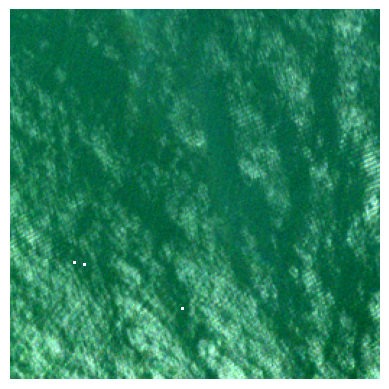

In [ ]:
# Nan

nan_patches = np.where(np.isnan(X).any(axis=(1,2,3)))[0]
print("Patches with NaNs:", nan_patches)

show_rgb(X[788])

In [7]:
# Drop Nan patches

keep_mask = np.ones(len(X), dtype=bool)
keep_mask[nan_patches] = False

X = X[keep_mask]
y = y[keep_mask]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1678, 256, 256, 7)
y shape: (1678,)


In [4]:
# Replace NaNs and Infs with 0
#X = np.nan_to_num(X, nan=0.0)

# Split - no test
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.3, 
    stratify=y, 
    random_state=42
)

# Normalize
mean = np.nanmean(X_train, axis=(0,1,2))  # mean per band
std  = np.nanstd(X_train, axis=(0,1,2))   # std per band
X_train = (X_train - mean) / std
X_val = (X_val - mean) / std

# # Check for NaNs
# assert not np.isnan(X_train).any(), "NaNs found in training data"
# assert not np.isnan(X_val).any(), "NaNs found in validation data"

In [6]:
# Split -  with test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.3, 
    stratify=y, 
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)
# Normalize
mean = np.nanmean(X_train, axis=(0,1,2))  # mean per band
std  = np.nanstd(X_train, axis=(0,1,2))   # std per band
X_train = (X_train - mean) / std
X_val = (X_val - mean) / std
X_test = (X_test - mean) / std

In [9]:
# Count samples for each class
print(np.unique(y_train, return_counts=True))
print(np.unique(y_val, return_counts=True))

(array([0, 1]), array([843, 164]))
(array([0, 1]), array([181,  35]))


In [7]:
train_dataset = PatchDataset(X_train, y_train, augment=True)
val_dataset   = PatchDataset(X_val, y_val, augment=False)
test_dataset  = PatchDataset(X_test, y_test, augment=False)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Training and Validation

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(np.unique(y))
model = CNN(num_classes=num_classes, in_channels=7, log_features=False).to(device)

# Compute class weights
class_counts = np.bincount(y)
weights = 1.0 / class_counts
weights = torch.tensor(weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs=30
train_losses = []
valid_losses = []
train_acc = []
valid_acc = []

for epoch in range(num_epochs):
    print(f"Epoch [{epoch + 1}/{num_epochs}]")

    # Train
    model.train()
    running_loss_train = 0.0
    correct_train = 0
    total_train = 0

    for batch_index, (data, targets) in enumerate(tqdm(train_loader)):
        data, targets = data.to(device), targets.to(device)
        scores = model(data)
        loss = criterion(scores, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accumulate stats
        batch_size = targets.size(0)
        running_loss_train += loss.item() * batch_size
        _, preds = torch.max(scores, 1)
        correct_train += (preds == targets).sum().item()
        total_train += batch_size

    # Evaluate
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for data, targets in val_loader:
            data, targets = data.to(device), targets.to(device)
            batch_size = targets.size(0)
            scores = model(data)
            loss = criterion(scores, targets)
            running_val_loss += loss.item() * batch_size
            _, preds = torch.max(scores, 1)
            correct_val += (preds == targets).sum().item()
            total_val += batch_size

    # Compute epoch-level metrics
    train_epoch_loss = running_loss_train / total_train
    train_losses.append(train_epoch_loss)
    train_epoch_acc = correct_train / total_train
    train_acc.append(train_epoch_acc)
    print(f"Train Loss: {train_epoch_loss:.4f}, Accuracy: {train_epoch_acc:.4f}")

    val_epoch_loss = running_val_loss / total_val
    valid_losses.append(val_epoch_loss)
    val_epoch_acc = correct_val / total_val
    valid_acc.append(val_epoch_acc)
    print(f"Validation Loss: {val_epoch_loss:.4f}, Accuracy: {val_epoch_acc:.4f}")

Epoch [1/30]


100%|██████████| 16/16 [01:58<00:00,  7.39s/it]


Train Loss: 0.6500, Accuracy: 0.5621
Validation Loss: 0.5945, Accuracy: 0.5139
Epoch [2/30]


100%|██████████| 16/16 [02:13<00:00,  8.35s/it]


Train Loss: 0.6225, Accuracy: 0.6862
Validation Loss: 0.6125, Accuracy: 0.4861
Epoch [3/30]


100%|██████████| 16/16 [02:07<00:00,  7.95s/it]


Train Loss: 0.6031, Accuracy: 0.6256
Validation Loss: 0.5468, Accuracy: 0.7593
Epoch [4/30]


100%|██████████| 16/16 [02:06<00:00,  7.89s/it]


Train Loss: 0.6027, Accuracy: 0.6773
Validation Loss: 0.5851, Accuracy: 0.5602
Epoch [5/30]


100%|██████████| 16/16 [02:00<00:00,  7.53s/it]


Train Loss: 0.5933, Accuracy: 0.7071
Validation Loss: 0.5649, Accuracy: 0.6528
Epoch [6/30]


100%|██████████| 16/16 [02:05<00:00,  7.86s/it]


Train Loss: 0.5825, Accuracy: 0.7249
Validation Loss: 0.5704, Accuracy: 0.6435
Epoch [7/30]


100%|██████████| 16/16 [02:17<00:00,  8.62s/it]


Train Loss: 0.5711, Accuracy: 0.7368
Validation Loss: 0.5494, Accuracy: 0.7315
Epoch [8/30]


100%|██████████| 16/16 [02:06<00:00,  7.90s/it]


Train Loss: 0.5716, Accuracy: 0.7160
Validation Loss: 0.5422, Accuracy: 0.7361
Epoch [9/30]


100%|██████████| 16/16 [02:06<00:00,  7.91s/it]


Train Loss: 0.5679, Accuracy: 0.7408
Validation Loss: 0.5869, Accuracy: 0.6157
Epoch [10/30]


100%|██████████| 16/16 [02:08<00:00,  8.04s/it]


Train Loss: 0.5622, Accuracy: 0.7408
Validation Loss: 0.5352, Accuracy: 0.7361
Epoch [11/30]


100%|██████████| 16/16 [02:11<00:00,  8.23s/it]


Train Loss: 0.5521, Accuracy: 0.7468
Validation Loss: 0.5316, Accuracy: 0.7361
Epoch [12/30]


100%|██████████| 16/16 [02:12<00:00,  8.27s/it]


Train Loss: 0.5501, Accuracy: 0.7498
Validation Loss: 0.5463, Accuracy: 0.6898
Epoch [13/30]


100%|██████████| 16/16 [02:06<00:00,  7.92s/it]


Train Loss: 0.5467, Accuracy: 0.7656
Validation Loss: 0.5427, Accuracy: 0.7176
Epoch [14/30]


100%|██████████| 16/16 [02:10<00:00,  8.14s/it]


Train Loss: 0.5571, Accuracy: 0.7498
Validation Loss: 0.5689, Accuracy: 0.6343
Epoch [15/30]


100%|██████████| 16/16 [02:09<00:00,  8.07s/it]


Train Loss: 0.5697, Accuracy: 0.7289
Validation Loss: 0.5240, Accuracy: 0.7269
Epoch [16/30]


100%|██████████| 16/16 [02:09<00:00,  8.12s/it]


Train Loss: 0.5408, Accuracy: 0.7200
Validation Loss: 0.5063, Accuracy: 0.7963
Epoch [17/30]


100%|██████████| 16/16 [02:13<00:00,  8.33s/it]


Train Loss: 0.5388, Accuracy: 0.7468
Validation Loss: 0.5098, Accuracy: 0.7546
Epoch [18/30]


100%|██████████| 16/16 [02:07<00:00,  7.96s/it]


Train Loss: 0.5449, Accuracy: 0.7567
Validation Loss: 0.5105, Accuracy: 0.7824
Epoch [19/30]


100%|██████████| 16/16 [02:07<00:00,  7.99s/it]


Train Loss: 0.5245, Accuracy: 0.7825
Validation Loss: 0.4905, Accuracy: 0.7731
Epoch [20/30]


100%|██████████| 16/16 [02:09<00:00,  8.06s/it]


Train Loss: 0.5267, Accuracy: 0.7577
Validation Loss: 0.5083, Accuracy: 0.7546
Epoch [21/30]


100%|██████████| 16/16 [02:09<00:00,  8.07s/it]


Train Loss: 0.5283, Accuracy: 0.7557
Validation Loss: 0.4937, Accuracy: 0.7824
Epoch [22/30]


100%|██████████| 16/16 [02:12<00:00,  8.31s/it]


Train Loss: 0.5158, Accuracy: 0.7786
Validation Loss: 0.4944, Accuracy: 0.7454
Epoch [23/30]


100%|██████████| 16/16 [02:06<00:00,  7.92s/it]


Train Loss: 0.5139, Accuracy: 0.7637
Validation Loss: 0.4798, Accuracy: 0.8102
Epoch [24/30]


100%|██████████| 16/16 [02:09<00:00,  8.11s/it]


Train Loss: 0.5057, Accuracy: 0.7795
Validation Loss: 0.4928, Accuracy: 0.7546
Epoch [25/30]


100%|██████████| 16/16 [02:06<00:00,  7.89s/it]


Train Loss: 0.5099, Accuracy: 0.7617
Validation Loss: 0.4844, Accuracy: 0.7593
Epoch [26/30]


100%|██████████| 16/16 [02:08<00:00,  8.03s/it]


Train Loss: 0.5054, Accuracy: 0.7637
Validation Loss: 0.4655, Accuracy: 0.8056
Epoch [27/30]


100%|██████████| 16/16 [02:10<00:00,  8.18s/it]


Train Loss: 0.4976, Accuracy: 0.7726
Validation Loss: 0.4853, Accuracy: 0.7454
Epoch [28/30]


100%|██████████| 16/16 [02:06<00:00,  7.88s/it]


Train Loss: 0.5069, Accuracy: 0.7766
Validation Loss: 0.4620, Accuracy: 0.7778
Epoch [29/30]


100%|██████████| 16/16 [02:06<00:00,  7.89s/it]


Train Loss: 0.4893, Accuracy: 0.7676
Validation Loss: 0.4610, Accuracy: 0.8102
Epoch [30/30]


100%|██████████| 16/16 [02:06<00:00,  7.90s/it]


Train Loss: 0.4962, Accuracy: 0.7766
Validation Loss: 0.4845, Accuracy: 0.7361


In [10]:
from sklearn.metrics import f1_score, roc_curve, auc

model.eval()
y_true, y_prob = [], []
running_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        logits = model(X_batch)  # (B, num_classes)
        loss = criterion(logits, y_batch)
        running_loss += loss.item() * X_batch.size(0)
        probs = torch.softmax(logits, dim=1)[:, 1]  # probability for mucilage class
        _, predicted = torch.max(logits, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

        y_true.extend(y_batch.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())

test_loss = running_loss / total
test_acc = correct / total
print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.3f}")

y_true = np.array(y_true)
y_prob = np.array(y_prob)
y_pred = (y_prob >= 0.7).astype(int)
f1 = f1_score(y_true, y_pred, average="binary")
print("F1 score:", f1)

# ROC + AUC
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"CNN (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - CNN")
plt.legend()
plt.savefig("cnn_roc.png", dpi=300)
plt.close()

y_pred = (y_prob >= 0.7).astype(int)
false_pos_idx = np.where((y_pred == 1) & (y_true == 0))[0]  # indices of FP samples
print("Number of false positives:", len(false_pos_idx))

Test loss: 0.5687, Test acc: 0.704
F1 score: 0.4731182795698925
Number of false positives: 36


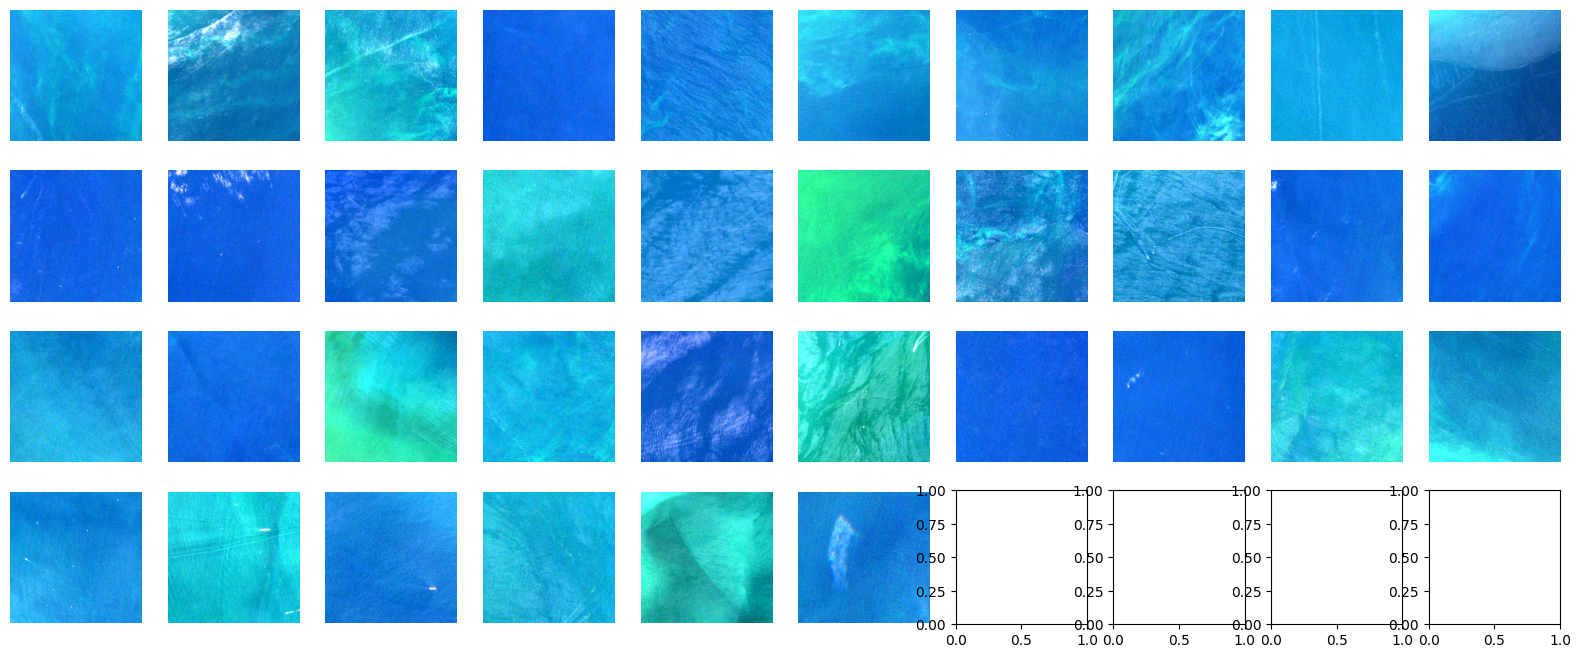

In [17]:
test_dataset = test_loader.dataset

import math
n_patches = len(false_pos_idx)
ncols = 10
nrows = math.ceil(n_patches / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(2*ncols, 2*nrows))
axes = np.array(axes).reshape(-1)  # flatten in case it's 2D

for ax, i in zip(axes, false_pos_idx):
    patch, label = test_dataset[i]   # X, y
    # If it's a tensor, move to numpy
    patch = patch.numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
    rgb = patch[:,:, [2,1,0]]
    p2, p98 = np.nanpercentile(rgb, (2, 98))
    rgb = np.clip((rgb - p2) / (p98 - p2 + 1e-6), 0, 1)
    ax.imshow(rgb)
    ax.axis("off")

## Kfold

In [ ]:
# K-Fold

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 20
batch_size = 32
k_folds = 5

kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

all_fold_train_losses = []
all_fold_valid_losses = []
all_fold_train_acc = []
all_fold_valid_acc = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"\n--- Fold {fold+1}/{k_folds} ---")

    # Create datasets for this fold
    train_dataset = PatchDataset(X[train_idx], y[train_idx], augment=True)
    val_dataset   = PatchDataset(X[val_idx], y[val_idx], augment=False)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


    # Reinitialize model for each fold
    num_classes = len(np.unique(y))
    model = CNN(num_classes=num_classes, in_channels=7, log_features=False).to(device)

    # Compute class weights from current training set
    class_counts = np.bincount(y[train_idx])
    weights = 1.0 / class_counts
    weights = torch.tensor(weights, dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    # Track losses/accuracies
    train_losses = []
    valid_losses = []
    train_acc = []
    valid_acc = []

    for epoch in range(num_epochs):
        print(f"Epoch [{epoch + 1}/{num_epochs}]")

        # --- Training ---
        model.train()
        running_loss_train = 0.0
        correct_train = 0
        total_train = 0

        for data, targets in tqdm(train_loader):
            data, targets = data.to(device), targets.to(device)
            scores = model(data)
            loss = criterion(scores, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            bs = targets.size(0)
            running_loss_train += loss.item() * bs
            _, preds = torch.max(scores, 1)
            correct_train += (preds == targets).sum().item()
            total_train += bs

        train_epoch_loss = running_loss_train / total_train
        train_losses.append(train_epoch_loss)
        train_epoch_acc = correct_train / total_train
        train_acc.append(train_epoch_acc)
        print(f"Train Loss: {train_epoch_loss:.4f}, Accuracy: {train_epoch_acc:.4f}")

        # --- Validation ---
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)
                scores = model(data)
                loss = criterion(scores, targets)

                bs = targets.size(0)
                running_val_loss += loss.item() * bs
                _, preds = torch.max(scores, 1)
                correct_val += (preds == targets).sum().item()
                total_val += bs

        val_epoch_loss = running_val_loss / total_val
        valid_losses.append(val_epoch_loss)
        val_epoch_acc = correct_val / total_val
        valid_acc.append(val_epoch_acc)
        print(f"Validation Loss: {val_epoch_loss:.4f}, Accuracy: {val_epoch_acc:.4f}")

    # Store fold results
    all_fold_train_losses.append(train_losses)
    all_fold_valid_losses.append(valid_losses)
    all_fold_train_acc.append(train_acc)
    all_fold_valid_acc.append(valid_acc)

# === After all folds ===
print("\n=== Cross-validation Summary ===")
for i in range(k_folds):
    print(f"Fold {i+1}: Final Val Loss={all_fold_valid_losses[i][-1]:.4f}, "
          f"Final Val Acc={all_fold_valid_acc[i][-1]:.4f}")

print(f"\nMean Final Val Loss: {np.mean([losses[-1] for losses in all_fold_valid_losses]):.4f}")
print(f"Mean Final Val Acc: {np.mean([acc[-1] for acc in all_fold_valid_acc]):.4f}")


--- Fold 1/5 ---
Epoch [1/20]


100%|██████████| 42/42 [02:34<00:00,  3.67s/it]


Train Loss: 0.7127, Accuracy: 0.4538
Validation Loss: 0.7154, Accuracy: 0.1667
Epoch [2/20]


100%|██████████| 42/42 [02:25<00:00,  3.46s/it]


Train Loss: 0.6977, Accuracy: 0.5186
Validation Loss: 0.7056, Accuracy: 0.1696
Epoch [3/20]


100%|██████████| 42/42 [02:21<00:00,  3.38s/it]


Train Loss: 0.6898, Accuracy: 0.6557
Validation Loss: 0.6775, Accuracy: 0.6548
Epoch [4/20]


100%|██████████| 42/42 [02:22<00:00,  3.40s/it]


Train Loss: 0.6819, Accuracy: 0.6334
Validation Loss: 0.6728, Accuracy: 0.4673
Epoch [5/20]


100%|██████████| 42/42 [02:27<00:00,  3.51s/it]


Train Loss: 0.6880, Accuracy: 0.6207
Validation Loss: 0.6824, Accuracy: 0.3185
Epoch [6/20]


100%|██████████| 42/42 [02:23<00:00,  3.42s/it]


Train Loss: 0.6778, Accuracy: 0.5529
Validation Loss: 0.6433, Accuracy: 0.8095
Epoch [7/20]


100%|██████████| 42/42 [02:23<00:00,  3.42s/it]


Train Loss: 0.6764, Accuracy: 0.6505
Validation Loss: 0.6320, Accuracy: 0.7351
Epoch [8/20]


100%|██████████| 42/42 [02:19<00:00,  3.31s/it]


Train Loss: 0.6705, Accuracy: 0.6580
Validation Loss: 0.7274, Accuracy: 0.2768
Epoch [9/20]


100%|██████████| 42/42 [02:22<00:00,  3.39s/it]


Train Loss: 0.6587, Accuracy: 0.6013
Validation Loss: 0.6739, Accuracy: 0.3661
Epoch [10/20]


100%|██████████| 42/42 [02:18<00:00,  3.30s/it]


Train Loss: 0.6399, Accuracy: 0.6677
Validation Loss: 0.7112, Accuracy: 0.3333
Epoch [11/20]


100%|██████████| 42/42 [02:22<00:00,  3.39s/it]


Train Loss: 0.6038, Accuracy: 0.6766
Validation Loss: 0.5577, Accuracy: 0.6518
Epoch [12/20]


100%|██████████| 42/42 [02:27<00:00,  3.50s/it]


Train Loss: 0.5812, Accuracy: 0.6975
Validation Loss: 0.5182, Accuracy: 0.7470
Epoch [13/20]


100%|██████████| 42/42 [02:23<00:00,  3.43s/it]


Train Loss: 0.5448, Accuracy: 0.7787
Validation Loss: 0.7595, Accuracy: 0.4167
Epoch [14/20]


100%|██████████| 42/42 [02:22<00:00,  3.38s/it]


Train Loss: 0.5215, Accuracy: 0.7444
Validation Loss: 0.5993, Accuracy: 0.5030
Epoch [15/20]


100%|██████████| 42/42 [02:23<00:00,  3.42s/it]


Train Loss: 0.4936, Accuracy: 0.7846
Validation Loss: 0.4914, Accuracy: 0.7143
Epoch [16/20]


100%|██████████| 42/42 [02:26<00:00,  3.49s/it]


Train Loss: 0.4962, Accuracy: 0.7615
Validation Loss: 0.4934, Accuracy: 0.6905
Epoch [17/20]


100%|██████████| 42/42 [02:21<00:00,  3.37s/it]


Train Loss: 0.4819, Accuracy: 0.8174
Validation Loss: 0.4549, Accuracy: 0.7887
Epoch [18/20]


100%|██████████| 42/42 [02:21<00:00,  3.37s/it]


Train Loss: 0.4736, Accuracy: 0.8070
Validation Loss: 0.4750, Accuracy: 0.7202
Epoch [19/20]


100%|██████████| 42/42 [02:25<00:00,  3.47s/it]


Train Loss: 0.4502, Accuracy: 0.8256
Validation Loss: 0.4837, Accuracy: 0.6994
Epoch [20/20]


100%|██████████| 42/42 [02:27<00:00,  3.51s/it]


Train Loss: 0.4694, Accuracy: 0.8241


In [ ]:
epochs = range(1, num_epochs + 1)

# Loss curves
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy curves
plt.subplot(1,2,2)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, valid_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Training results

In [ ]:
def visualize_feature_maps(model, x, layer_name="conv1"):
    """Visualize feature maps from a given layer"""
    feature_maps = None

    def hook_fn(module, input, output):
        nonlocal feature_maps
        feature_maps = output.detach().cpu()

    # Register hook
    hook = dict(model.named_modules())[layer_name].register_forward_hook(hook_fn)

    # Forward pass
    _ = model(x.unsqueeze(0))  # add batch dim

    # Remove hook
    hook.remove()

    # Plot first 6 feature maps
    fig, axes = plt.subplots(1, 7, figsize=(15, 5))
    for i in range(7):
        axes[i].imshow(feature_maps[0, i].numpy(), cmap="viridis")
        axes[i].axis("off")
        axes[i].set_title(f"Channel {i}")
    plt.show()

sample_x = X[10] 
sample_x = torch.from_numpy(sample_x).permute(2, 0, 1).float()
visualize_feature_maps(model, sample_x, layer_name="conv1")

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

target_layer = model.conv3  # last conv block

cam = GradCAM(model=model, target_layers=[target_layer])
input_tensor = sample_x.unsqueeze(0)
grayscale_cam = cam(input_tensor=input_tensor)[0, :]

fig, axes = plt.subplots(1, 7, figsize=(15, 5))
for i in range(7):
    band = sample_x[i].cpu().numpy()  # first band
    band = (band - band.min()) / (band.max() - band.min())
    axes[i].imshow(band, cmap="gray")
    axes[i].imshow(grayscale_cam, cmap="jet", alpha=0.5)  # overlay
    axes[i].axis("off")
plt.show()